In [88]:
from dotenv import load_dotenv
import os

load_dotenv()

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ['LANGCHAIN_PROJECT'] = "BuffetBot"
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

#### Tools

In [89]:
import ssl
from urllib.request import urlopen
import certifi
import json
from langchain_core.tools import tool
from typing import List, Optional, TypedDict, Annotated

# Function to clean the ticker input
def clean_ticker(ticker: str) -> str:
    return ticker.strip().upper()

# Function 1
@tool
def get_financial_key_metrics(ticker: str) -> str:
    """
    Retrieve all financial key metrics for a specified company.

    This function fetches financial data from the Financial Modeling Prep API
    and returns all the data as a formatted string.

    Parameters:
    ticker (str): The stock symbol of the company (e.g., "AAPL" for Apple Inc.).

    Returns:
    str: A formatted string containing all key metrics for the company.
    """
    ticker = clean_ticker(ticker)
    api_key = os.getenv('FINANCIAL_MODELING_PREP_API_KEY')
    url = f"https://financialmodelingprep.com/api/v3/key-metrics/{ticker}?apikey={api_key}"
    
    context = ssl.create_default_context(cafile=certifi.where())
    
    with urlopen(url, context=context) as response:
        data = response.read().decode("utf-8")
    
    json_data = json.loads(data)
    
    result = ""
    for item in json_data:
        result += "========================\n"
        for key, value in item.items():
            result += f"{key}: {value}\n"
    
    return result

# Function 2
@tool
def get_financial_ratios(ticker: str) -> str:
    """
    Retrieve all financial ratios for a specified company.

    This function fetches financial ratio data from the Financial Modeling Prep API
    and returns all the data as a formatted string.

    Parameters:
    ticker (str): The stock symbol of the company (e.g., "AAPL" for Apple Inc.).

    Returns:
    str: A formatted string containing all financial ratios for the company.
    """
    ticker = clean_ticker(ticker)
    api_key = os.getenv('FINANCIAL_MODELING_PREP_API_KEY')
    url = f"https://financialmodelingprep.com/api/v3/ratios/{ticker}?&apikey={api_key}"
    
    context = ssl.create_default_context(cafile=certifi.where())
    
    with urlopen(url, context=context) as response:
        data = response.read().decode("utf-8")
    
    json_data = json.loads(data)
    
    result = ""
    for item in json_data:
        result += "========================\n"
        for key, value in item.items():
            result += f"{key}: {value}\n"
    
    return result

# Function 3
# Will add more functions as needed

tools = [get_financial_key_metrics, get_financial_ratios]

#### State

In [102]:
#State
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.documents import Document

class State(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    tickers: Optional[List[str]]
    financial_summary: Optional[str]
    chunked_docs: Optional[List[Document]]
    routing_decision: Optional[str]  # Add this line

#### Router

In [103]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the appropriate action."""

    action: Literal["company_specific", "general_knowledge"] = Field(
        ...,
        description="Given a user question, choose whether it's company-specific or general knowledge.",
    )

# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at determining whether a query is about a specific company or financial data, or if it's a general knowledge question.
For queries about specific companies, financial metrics, stock performance, or company-specific data, use 'company_specific'.
For general knowledge questions, including explanations of financial concepts not tied to a specific company, use 'general_knowledge'."""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

def router(state: State) -> State:
    last_message = state["messages"][-1].content if state["messages"] else ""
    result = question_router.invoke({"question": last_message})
    
    # Update the state with the routing decision
    state['routing_decision'] = result.action
    
    return state

##### Test the router function 

In [72]:
# Test the router function

# Sample queries
test_queries = [
    "What are Apple's financial ratios?",
    "How do I calculate return on investment?",
    "Can you explain Tesla's recent stock performance?",
    "What is the difference between stocks and bonds?",
    "What was Amazon's revenue last quarter?",
    "What factors affect a company's price-to-earnings ratio?",
    "How has the tech sector performed over the last year?",
]


# Run tests
for query in test_queries:
    mock_state = create_mock_state(query)
    result = router(mock_state)
    print(f"Query: {query}")
    print(f"Decision: {result}")
    print("---")

Query: What are Apple's financial ratios?
Decision: company_specific
---
Query: How do I calculate return on investment?
Decision: general_knowledge
---
Query: Can you explain Tesla's recent stock performance?
Decision: company_specific
---
Query: What is the difference between stocks and bonds?
Decision: general_knowledge
---
Query: What was Amazon's revenue last quarter?
Decision: company_specific
---
Query: What factors affect a company's price-to-earnings ratio?
Decision: general_knowledge
---
Query: How has the tech sector performed over the last year?
Decision: general_knowledge
---


#### Knowledge Base Retriever

In [112]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser


embeddings = OpenAIEmbeddings()

vector_store = FAISS.load_local(
    "knowledge_base", embeddings, allow_dangerous_deserialization=True
)
retriever = vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 5})

# RAG Fusion
from langchain.prompts import ChatPromptTemplate

#------------------------------
# RAG-Fusion Question Generating Prompt
template = """You are a financial assistant that takes questions for Warren Buffet and generates multiple queries, so that Warren understands them properly \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
#------------------------------

prompt_rag_fusion = ChatPromptTemplate.from_template(template)

generate_queries = (
    prompt_rag_fusion 
    | ChatOpenAI(temperature=0)
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

# Reciprocal Ranking
from langchain.load import dumps, loads

def format_docs(docs):
    if not isinstance(docs, list):
        raise ValueError("Error: Expected a list of documents")
    
    formatted_docs = []
    for i, item in enumerate(docs):
        if not (isinstance(item, tuple) and len(item) == 2 and hasattr(item[0], 'page_content')):
            raise ValueError(f"Error: Item at index {i} is not in the expected RAG Fusion format")
        formatted_docs.append(item[0].page_content)
    
    return "\n\n".join(formatted_docs)

def reciprocal_rank_fusion(results: list[list], k=60, n=5):

    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results[:5]

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion | format_docs

def retrieve_docs(state: State) -> State:
    last_message = state["messages"][-1].content if state["messages"] else ""
    retrieved_docs = retrieval_chain_rag_fusion.invoke({"question": last_message})
    state['chunked_docs'] = retrieved_docs
    return state

##### Test RAG Fusion

In [113]:
test_query = "What is the difference between stocks and bonds?"
test_results = retrieval_chain_rag_fusion.invoke({"question": test_query})
print(test_results)

els. That was too good to be true. At long last the stock market has
“returned to normal,” in the sense that both speculators and stock
investors must again be prepared to experience significant and per-
haps protracted falls as well as rises in the value of their holdings.
In the area of many secondary and third-line common stocks,
especially recently floated enterprises, the havoc wrought by thelast market break was catastrophic. This was nothing new initself—it had happened to a similar degree in 1961–62—but there
was now a novel element in the fact that some of the investment
funds had large commitments in highly speculative and obviouslyovervalued issues of this type. Evidently it is not only the tyro who
needs to be warned that while enthusiasm may be necessary for
great accomplishments elsewhere, on Wall Street it almost invari-ably leads to disaster.
The major question we shall have to deal with grows out of the
huge rise in the rate of interest on first-quality bonds. Since la

#### Ticker Extractor

In [93]:
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

# Data model for ticker extraction
class TickerExtraction(BaseModel):
    """Extract the relevant stock tickers from a user query."""

    tickers: List[str] = Field(
        default_factory=list,
        description="The stock tickers mentioned or implied in the query. Use an empty list if no specific companies are mentioned.",
    )

# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_ticker_extractor = llm.with_structured_output(TickerExtraction)

# Prompt
system = """You are an expert at identifying company stock tickers in financial queries.
If specific companies are mentioned or strongly implied, provide their stock tickers as a list.
If no specific companies are mentioned or implied, return an empty list.
Always provide a brief explanation for your decision."""

ticker_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

ticker_extractor = ticker_prompt | structured_llm_ticker_extractor

def extract_ticker(state: State) -> State:
    last_message = state["messages"][-1].content if state["messages"] else ""
    result = ticker_extractor.invoke({"question": last_message})
    
    state['tickers'] = result.tickers
    
    return state

In [55]:
# Test the ticker extractor

# Sample queries
test_queries = [
    "What are Apple's financial ratios?",
    "How do I calculate return on investment?",
    "Can you explain Tesla's recent stock performance?",
    "Compare Microsoft and Google's profit margins",
    "What's the latest news on Amazon?",
]

# Create a mock state for testing
def create_mock_state(query):
    return {
        "messages": [{"role": "human", "content": query}],
        "tickers": [],
        "observations": None,
        "company_summary": None,
        "chunked_docs": None
    }

# Run tests
for query in test_queries:
    initial_state = create_mock_state(query)
    updated_state = extract_ticker(initial_state)
    print(f"Query: {query}")
    print(f"Initial State Tickers: {initial_state['tickers']}")
    print(f"Updated State Tickers: {updated_state['tickers']}")
    print("---")

Query: What are Apple's financial ratios?
Initial State Tickers: []
Updated State Tickers: ['AAPL']
---
Query: How do I calculate return on investment?
Initial State Tickers: []
Updated State Tickers: []
---
Query: Can you explain Tesla's recent stock performance?
Initial State Tickers: []
Updated State Tickers: ['TSLA']
---
Query: Compare Microsoft and Google's profit margins
Initial State Tickers: []
Updated State Tickers: ['MSFT', 'GOOGL']
---
Query: What's the latest news on Amazon?
Initial State Tickers: []
Updated State Tickers: ['AMZN']
---


#### API Agent

In [96]:
from langchain.agents import AgentExecutor, create_react_agent
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
prompt = ChatPromptTemplate.from_template("""
You are a financial analysis assistant powered by Warren Buffett's investment philosophy. Your job is to gather data relevant to the question as best as you can and prepare a good summary.
You have access to the following tools:

{tools}

Use the following format:

Question: The question you must provide relevant information on.
Ticker: The company you should research

Thought: Reflect on what information you need to answer the question and which tool should provide you with the best information. 

Action: Choose one of [{tool_names}]
Action Input: The input to the tool call. This must be ONLY the ticker symbol, with no additional characters, spaces, or formatting. For example: AAPL

Observation: The result of the action
... (this Thought/Action/Action Input/Observation can be repeated as necessary)

Thought: I now have sufficient information to provide a comprehensive summary

Final Answer: Provide a detailed summary of the relevant financial metrics/ratios and their significance in answering the question, incorporating Warren Buffett's investment principles where applicable.

Begin your analysis:

Question: {input}
Ticker: {ticker}
Thought:{agent_scratchpad}""")

agent = create_react_agent(model, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

def execute_financial_analysis(state: State) -> State:
    last_message = state['messages'][-1].content
    tickers = state['tickers']
    
    result = agent_executor.invoke(
        {
            "input": last_message,
            "ticker": tickers
        }
    )
    
    state['financial_summary'] = result['output']
 
    return state

In [62]:
# Test execute_financial_analysis function
test_state = {
    'messages': [{'content': 'What is the current P/E ratio and debt-to-equity ratio for Apple?'}],
    'tickers': 'AAPL'
}

result_state = execute_financial_analysis(test_state)

print("Financial Summary:")
print(result_state['financial_summary'])




> Entering new AgentExecutor chain...
To answer the question regarding the current P/E ratio and debt-to-equity ratio for Apple, I need to gather the relevant financial metrics that include these specific ratios. The best tool for this purpose is `get_financial_key_metrics`, as it will provide the necessary key financial metrics, including the P/E ratio and debt-to-equity ratio.

Action: get_financial_key_metrics  
Action Input: AAPL  
[{'symbol': 'AAPL', 'date': '2023-09-30', 'operatingCashFlowPerShare': 7.021174930677783, 'interestCoverageRatio': 29.062039155860667, 'workingCapital': -1742000000, 'daysSalesOutstanding': 58.07564866874519, 'bookValuePerShare': 3.947223589389663, 'dividendYield': 0.005573960673721321, 'currentRatio': 0.9880116717592975, 'payablesTurnover': 3.420117870661705}, {'symbol': 'AAPL', 'date': '2022-09-24', 'operatingCashFlowPerShare': 7.532762624088375, 'interestCoverageRatio': 40.74957352439441, 'workingCapital': -18577000000, 'daysSalesOutstanding': 56.40

#### Buffet Agent

In [95]:
# Buffet Agent
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = ChatOpenAI(model="gpt-4o-mini")

def buffet_agent(state: State) -> State:
    messages = state['messages']
    chunked_docs = state.get('chunked_docs', [])
    financial_summary = state.get('company_summary', '') if 'financial_summary' in state else ''

    # Construct the prompt
    template = f"""
    You are Warren Buffett, the legendary investor known for your value investing approach and long-term perspective. 
    You have been asked to provide investment advice based on the following information:

    Message History:
    {' '.join([m.content for m in messages[:-1]])}

    Question: {messages[-1].content}

    Financial Analysis:
    {financial_summary}

    Buffet's Investment Philosophy:
    {' '.join(chunked_docs)}

    Based on this information and your investment philosophy, provide your thoughts and advice on the question
    """
    prompt = ChatPromptTemplate.from_template(template)

    buffetbot = prompt | llm | StrOutputParser()
    response = buffetbot.invoke({"messages": messages, "chunked_docs": chunked_docs, "financial_summary": financial_summary})

    # Append the response to the state as a new message
    state['messages'].append({
        'role': 'assistant',
        'content': response
    })

    return state


In [67]:
# Test buffet_agent with different inputs

# Sample chunked_docs
sample_chunked_docs = [
    "Focus on companies with strong fundamentals and a competitive advantage.",
    "Invest for the long term and ignore short-term market fluctuations.",
    "Look for businesses with consistent earnings and high return on equity.",
    "Prioritize management quality and integrity when evaluating companies."
]

# Sample financial summary
sample_financial_summary = """
Company XYZ:
- Revenue: $1.5 billion (up 10% YoY)
- Net Income: $300 million (up 15% YoY)
- P/E Ratio: 18.5
- Debt-to-Equity Ratio: 0.4
- Return on Equity: 22%
"""

# Test cases
test_cases = [
    {
        "messages": [
            {"role": "user", "content": "What do you think about investing in tech stocks?"}
        ],
        "chunked_docs": sample_chunked_docs,
        "financial_summary": None
    },
    {
        "messages": [
            {"role": "user", "content": "Should I invest in Company XYZ?"}
        ],
        "chunked_docs": sample_chunked_docs,
        "financial_summary": sample_financial_summary
    },
    {
        "messages": [
            {"role": "user", "content": "How important is dividend yield in your investment strategy?"}
        ],
        "chunked_docs": sample_chunked_docs,
        "financial_summary": None
    }
]

# Run tests
for i, test_case in enumerate(test_cases, 1):
    print(f"\nTest Case {i}:")
    state = {
        "messages": test_case["messages"],
        "chunked_docs": test_case["chunked_docs"],
        "financial_summary": test_case["financial_summary"]
    }
    
    result_state = buffet_agent(state)
    
    print(f": {test_case['messages'][-1]['content']}")
    print(f"Financial Summary Used: {'Yes' if test_case['financial_summary'] else 'No'}")
    print("-" * 50)



Test Case 1:
: Investing in tech stocks can be an attractive opportunity, but it is essential to approach this sector with the same principles I apply to all of my investments. Here are some key considerations:

1. **Fundamentals Matter**: Look for tech companies that have strong fundamentals. This includes consistent revenue growth, profitability, and a healthy balance sheet. Many tech companies may show rapid growth, but it’s crucial to assess whether that growth is sustainable and backed by solid financial metrics.

2. **Competitive Advantage**: Identify companies that possess a durable competitive advantage, often referred to as an "economic moat." This could come from unique technology, strong brand recognition, or a large customer base that provides them with pricing power and stability.

3. **Management Quality**: Evaluate the management teams of the tech companies you are considering. Strong leadership with a track record of making sound decisions, maintaining ethical standard

#### Graph

In [115]:

# Graph
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import HumanMessage
graph = StateGraph(State)

graph.add_node("Router", router)
graph.add_node("DocRetriever", retrieve_docs)
graph.add_node("TickerExtractor", extract_ticker)
graph.add_node("FinancialAnalyst", execute_financial_analysis)
graph.add_node("BuffetAgent", buffet_agent)

graph.add_edge(START, "Router")
graph.add_conditional_edges(
    "Router",
    lambda x: x['routing_decision'],
    {
        "general_knowledge": "DocRetriever",
        "company_specific": "TickerExtractor"
    }
)

graph.add_edge("DocRetriever", "BuffetAgent")
graph.add_edge("TickerExtractor", "FinancialAnalyst")
graph.add_edge("FinancialAnalyst", "DocRetriever")
graph.add_edge("BuffetAgent", END)

multi_agent_graph = graph.compile()


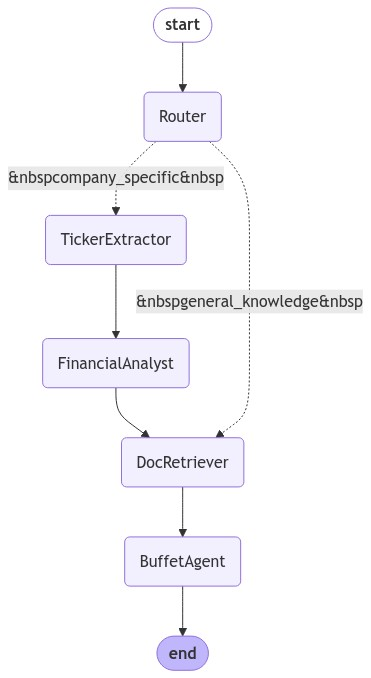

In [79]:
from IPython.display import Image, display

display(Image(multi_agent_graph.get_graph(xray=True).draw_mermaid_png()))

In [116]:
# Initialize the state with a message
initial_state = State(
    messages=[HumanMessage(content="What is the current P/E ratio for Apple?")],
    tickers=None,
    financial_summary=None,
    chunked_docs=None,
    routing_decision=None
)

# Run the graph with the initial state
for s in multi_agent_graph.stream(initial_state):
    if "__end__" not in s:
        print(s)
        print("---")


{'Router': {'messages': [HumanMessage(content='What is the current P/E ratio for Apple?', id='bb5886ed-63e9-4015-9027-c0ab149d065e')], 'tickers': None, 'financial_summary': None, 'chunked_docs': None, 'routing_decision': 'company_specific'}}
---
{'TickerExtractor': {'messages': [HumanMessage(content='What is the current P/E ratio for Apple?', id='bb5886ed-63e9-4015-9027-c0ab149d065e')], 'tickers': ['AAPL'], 'financial_summary': None, 'chunked_docs': None}}
---


> Entering new AgentExecutor chain...
To determine the current P/E (Price-to-Earnings) ratio for Apple Inc. (AAPL), I need to gather financial ratio data, as the P/E ratio is a key financial metric that falls under this category. The P/E ratio is significant because it helps investors assess the valuation of a company relative to its earnings, which is a fundamental aspect of Warren Buffett's investment philosophy—investing in companies that are undervalued compared to their intrinsic worth.

Action: get_financial_ratios  
Acti